In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import make_scorer, accuracy_score
from tensorflow.keras import callbacks


df_train = pd.read_csv('sign_mnist_train.csv')
df_test = pd.read_csv('sign_mnist_test.csv')

df_train.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27455 entries, 0 to 27454
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 164.4 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7172 entries, 0 to 7171
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 43.0 MB


In [ ]:
labels_mapping = {
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'E',
    5: 'F',
    6: 'G',
    7: 'H',
    8: 'I',
    # No label for J (9)
    10: 'K',
    11: 'L',
    12: 'M',
    13: 'N',
    14: 'O',
    15: 'P',
    16: 'Q',
    17: 'R',
    18: 'S',
    19: 'T',
    20: 'U',
    21: 'V',
    22: 'W',
    23: 'X',
    24: 'Y'
    # No label for Z (25)
}

In [ ]:
# Shuffle the dataset
df_train = shuffle(df_train, random_state=42)

In [ ]:
labels_train = df_train['label'].values
pixels_train = df_train.drop('label', axis=1).values.reshape(-1, 28, 28, 1)

labels_test = df_test['label'].values
pixels_test = df_test.drop('label', axis=1).values.reshape(-1, 28, 28, 1)

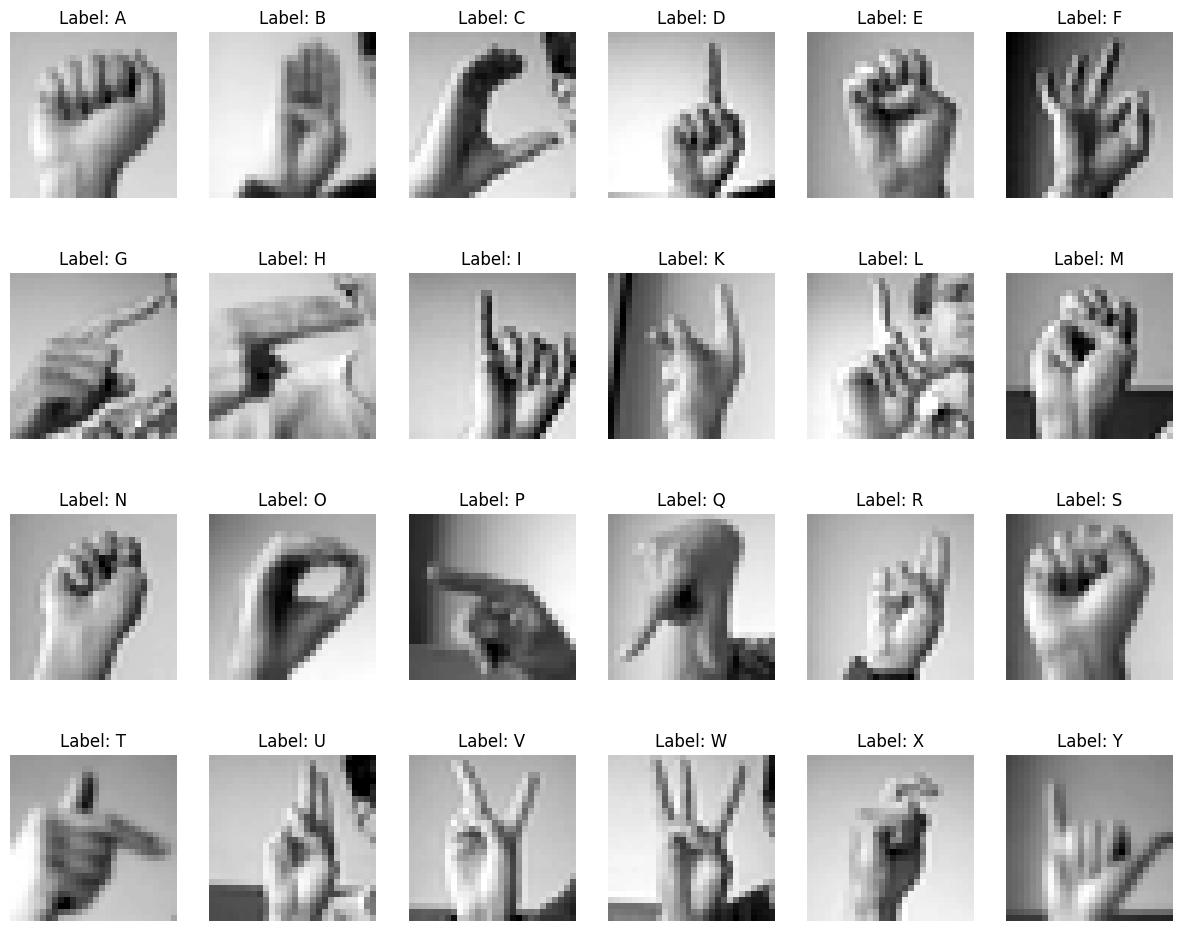

In [ ]:
import matplotlib.pyplot as plt
import random

# Get unique labels
unique_labels = np.unique(labels_train)

# Set the number of images per row and column
images_per_row = 6
images_per_column = 4

# Calculate the number of rows needed
num_rows = int(np.ceil(len(unique_labels) / images_per_row))

# Plot one image from each label
plt.figure(figsize=(15, 3 * num_rows))
for i, label in enumerate(unique_labels, 1):
    # Find the index of the first occurrence of the label
    idx = np.where(labels_train == label)[0][0]

    plt.subplot(num_rows, images_per_row, i)
    plt.imshow(pixels_train[idx].reshape(28, 28), cmap='gray')
    plt.title(f'Label: {labels_mapping.get(label, "Unknown")}')
    plt.axis('off')

plt.show()

In [ ]:
label_binarizer = LabelBinarizer()
labels_train = label_binarizer.fit_transform(labels_train)

label_binarizer = LabelBinarizer()
labels_test = label_binarizer.fit_transform(labels_test)

In [ ]:
# Normalize pixel values to the range [0, 1]
pixels_train = pixels_train / 255.0
pixels_test = pixels_test / 255.0

In [ ]:
# Use ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=30,
    fill_mode='nearest'
)

In [ ]:
import numpy as np
from tensorflow.keras import models, layers, callbacks
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import ParameterGrid
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Assuming you have loaded and preprocessed your data
# (pixels_train, labels_train, pixels_val, labels_val, pixels_test, labels_test)
pixels_train, pixels_val, labels_train, labels_val = train_test_split(
    pixels_train, labels_train, test_size=0.2, random_state=42
)

In [ ]:
def build_cnn_model_final(dense_units=64, optimizer='adam', learning_rate=0.01, momentum=0.9, filters1=32, filters2=64):
    model = models.Sequential()
    model.add(layers.Conv2D(filters1, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(filters2, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(filters2, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(dense_units, activation='relu'))
    model.add(layers.Dense(96, activation='relu'))
    model.add(layers.Dense(24, activation='softmax'))


    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

    return model

Epoch 1/5
687/687 [==============================] - 63s 91ms/step - loss: 2.0363 - accuracy: 0.3632 - val_loss: 0.7673 - val_accuracy: 0.7376
Epoch 2/5
687/687 [==============================] - 60s 87ms/step - loss: 0.2455 - accuracy: 0.9197 - val_loss: 0.1218 - val_accuracy: 0.9574
Epoch 3/5
687/687 [==============================] - 65s 95ms/step - loss: 0.0405 - accuracy: 0.9881 - val_loss: 0.0399 - val_accuracy: 0.9920
Epoch 4/5
687/687 [==============================] - 59s 86ms/step - loss: 0.0098 - accuracy: 0.9976 - val_loss: 3.7403e-04 - val_accuracy: 1.0000
Epoch 5/5
687/687 [==============================] - 62s 90ms/step - loss: 2.3896e-04 - accuracy: 1.0000 - val_loss: 1.6221e-04 - val_accuracy: 1.0000


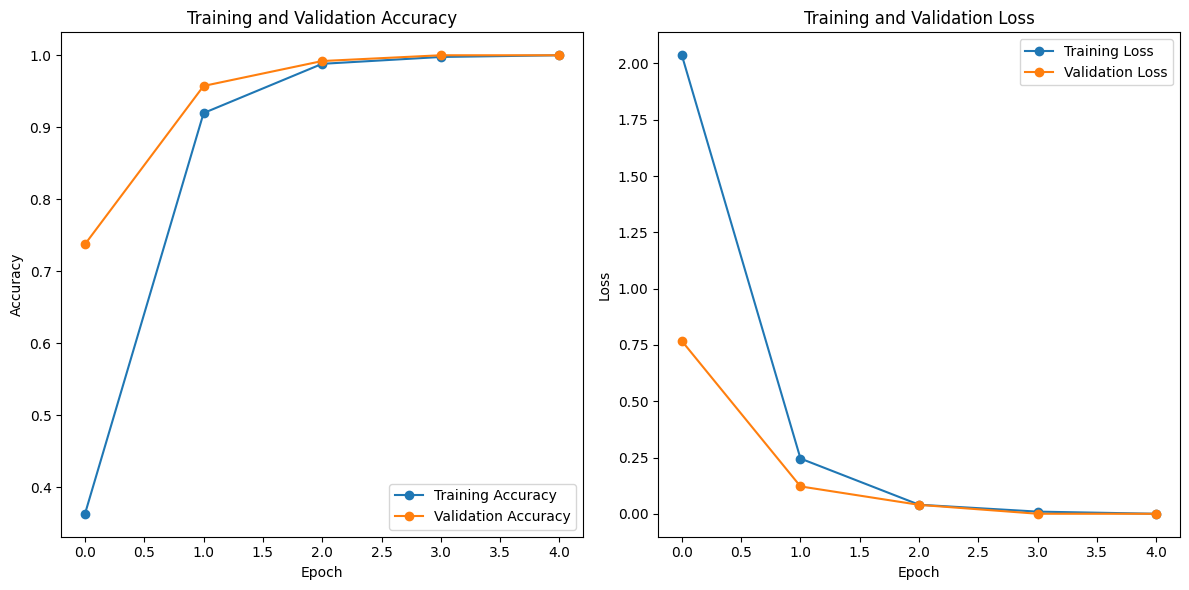

In [ ]:
# Model Without Data Augmentation
final_model1 = build_cnn_model_final(dense_units=128, optimizer='sgd', learning_rate=0.01, momentum=0.9, filters1=64, filters2=128)

early_stopping1 = callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history1 = final_model1.fit(pixels_train, labels_train,
                            epochs=5,
                            batch_size=32,
                            validation_data=(pixels_val, labels_val),
                            callbacks=[early_stopping1])

# After training
history_dict = history1.history

# Plotting the training history
plt.figure(figsize=(12, 6))

# Plot Training Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training Loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss', marker='o')
plt.plot(history_dict['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
_, val_accuracy1 = final_model1.evaluate(pixels_val, labels_val, verbose=0)
print("Validation Accuracy without Augmentation:", val_accuracy1)

_, test_accuracy1 = final_model1.evaluate(pixels_test, labels_test, verbose=0)
print("Test Accuracy without Augmentation:", test_accuracy1)

Validation Accuracy without Augmentation: 1.0
Test Accuracy without Augmentation: 0.9178750514984131


In [ ]:
print("Training Accuracy without Augmentation:", history_dict['accuracy'][-1])

Training Accuracy without Augmentation: 1.0


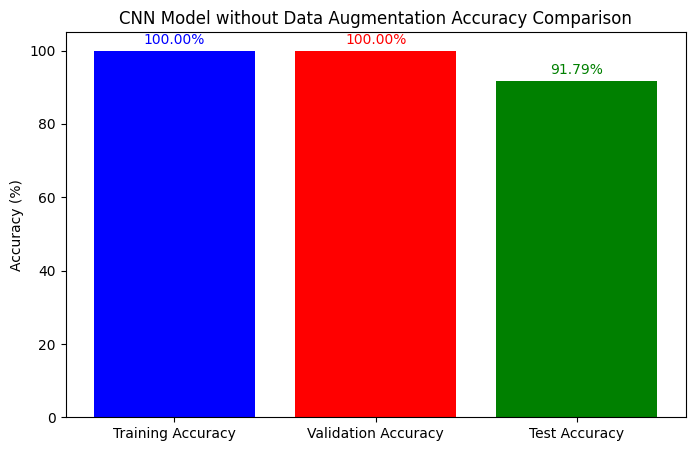

In [ ]:
import matplotlib.pyplot as plt

# Data
categories = ['Training Accuracy', 'Validation Accuracy', 'Test Accuracy']
accuracies_no_augmentation = [1.0, 1.0, 0.9178750514984131]

# Convert accuracies to percentages
accuracies_percentage_no_augmentation = [acc * 100 for acc in accuracies_no_augmentation]

# Plotting
fig, ax = plt.subplots(figsize=(8, 5))

bars = ax.bar(categories, accuracies_percentage_no_augmentation, color=['blue', 'red', 'green'])

ax.set_ylabel('Accuracy (%)')
ax.set_title('CNN Model without Data Augmentation Accuracy Comparison')

# Adding labels outside the bars
for bar, value in zip(bars, accuracies_percentage_no_augmentation):
    ax.text(bar.get_x() + bar.get_width() / 2, value + 1, f'{value:.2f}%', ha='center', va='bottom', color=bar.get_facecolor())

plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Make predictions on the test set
y_pred = final_model1.predict(pixels_test)

# Convert one-hot encoded labels back to integer labels
y_true = np.argmax(labels_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print classification report
print("\nClassification Report: CNN Model without Data Augmentation")
print(classification_report(y_true, y_pred_classes))

225/225 [==============================] - 4s 19ms/step

Classification Report: CNN Model without Data Augmentation
              precision    recall  f1-score   support

           0       0.93      1.00      0.97       331
           1       1.00      1.00      1.00       432
           2       0.94      1.00      0.97       310
           3       1.00      0.97      0.98       245
           4       0.94      0.99      0.97       498
           5       1.00      1.00      1.00       247
           6       0.94      0.88      0.91       348
           7       1.00      0.91      0.95       436
           8       0.94      0.98      0.96       288
           9       0.94      1.00      0.97       331
          10       0.97      1.00      0.98       209
          11       0.82      0.91      0.86       394
          12       0.76      0.80      0.78       291
          13       0.99      0.76      0.86       246
          14       0.96      1.00      0.98       347
          15       

Epoch 1/5
687/687 [==============================] - 73s 104ms/step - loss: 2.7431 - accuracy: 0.1553 - val_loss: 1.8599 - val_accuracy: 0.3713
Epoch 2/5
687/687 [==============================] - 85s 124ms/step - loss: 1.3433 - accuracy: 0.5422 - val_loss: 0.7118 - val_accuracy: 0.7654
Epoch 3/5
687/687 [==============================] - 94s 137ms/step - loss: 0.5681 - accuracy: 0.8028 - val_loss: 0.2053 - val_accuracy: 0.9339
Epoch 4/5
687/687 [==============================] - 81s 117ms/step - loss: 0.2648 - accuracy: 0.9092 - val_loss: 0.1013 - val_accuracy: 0.9661
Epoch 5/5
687/687 [==============================] - 81s 118ms/step - loss: 0.1505 - accuracy: 0.9492 - val_loss: 0.0822 - val_accuracy: 0.9687


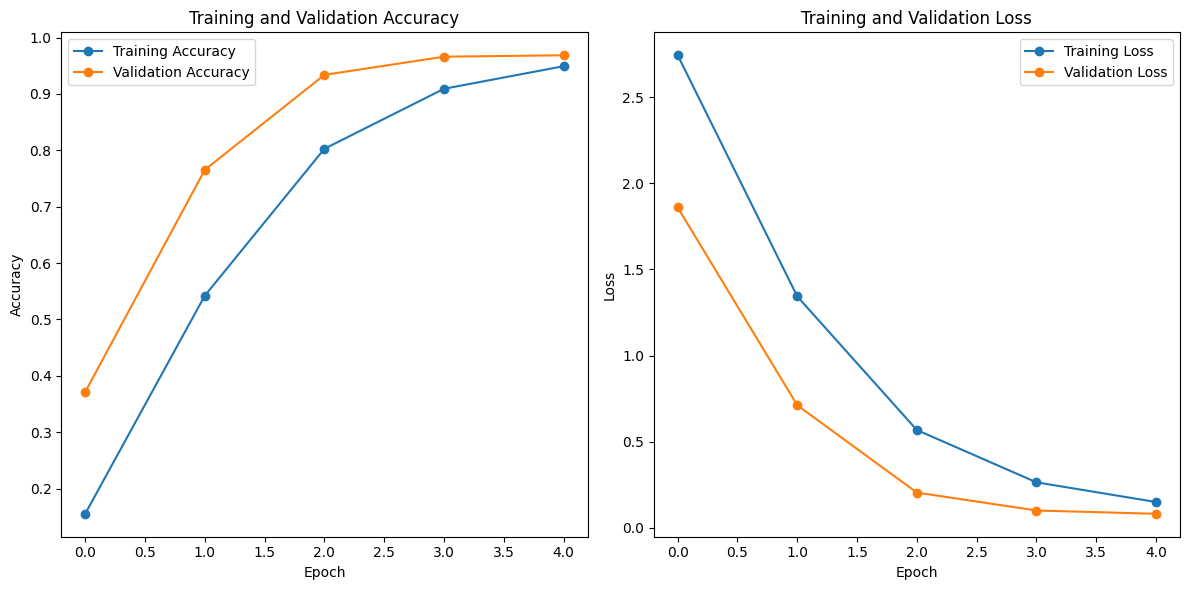

In [ ]:
# Model With Data Augmentation
augmented_datagen = datagen.flow(pixels_train, labels_train)


# Rest of your code
final_model2 = build_cnn_model_final(dense_units=128, optimizer='sgd', learning_rate=0.01, momentum=0.9, filters1=64, filters2=128)

early_stopping2 = callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
#graph_callback2 = LambdaCallback(on_batch_end=lambda batch, logs: plot_history(i=2))

history2 = final_model2.fit(augmented_datagen,
                          epochs=5,
                          validation_data=(pixels_val, labels_val),
                          callbacks=[early_stopping2])

# After training
history_dict2 = history2.history

# Plotting the training history
plt.figure(figsize=(12, 6))

# Plot Training Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_dict2['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history_dict2['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training Loss
plt.subplot(1, 2, 2)
plt.plot(history_dict2['loss'], label='Training Loss', marker='o')
plt.plot(history_dict2['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
_, val_accuracy2 = final_model2.evaluate(pixels_val, labels_val, verbose=0)
print("Validation Accuracy with Augmentation:", val_accuracy2)

_, test_accuracy2 = final_model2.evaluate(pixels_test, labels_test, verbose=0)
print("Test Accuracy with Augmentation:", test_accuracy2)

Validation Accuracy with Augmentation: 0.9686760306358337
Test Accuracy with Augmentation: 0.9192693829536438


In [ ]:
print("Training Accuracy with Augmentation:", history_dict2['accuracy'][-1])

Training Accuracy with Augmentation: 0.9492351412773132


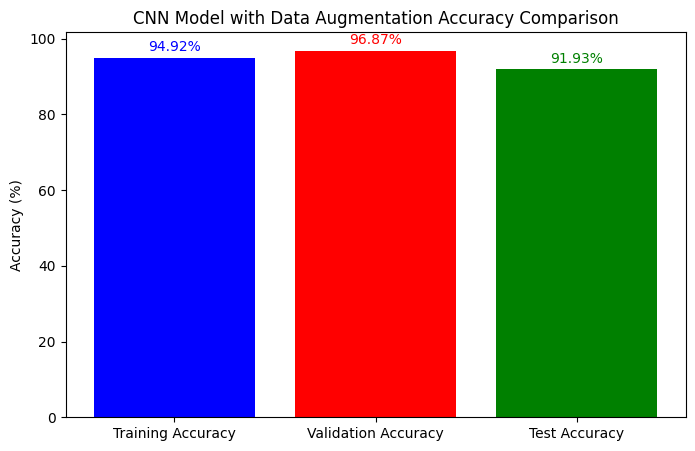

In [ ]:
import matplotlib.pyplot as plt

# Data
categories = ['Training Accuracy', 'Validation Accuracy', 'Test Accuracy']
accuracies_augmentation = [0.9492351412773132, 0.9686760306358337, 0.9192693829536438]

# Convert accuracies to percentages
accuracies_percentage_augmentation = [acc * 100 for acc in accuracies_augmentation]

# Plotting
fig, ax = plt.subplots(figsize=(8, 5))

bars = ax.bar(categories, accuracies_percentage_augmentation, color=['blue', 'red', 'green'])

ax.set_ylabel('Accuracy (%)')
ax.set_title('CNN Model with Data Augmentation Accuracy Comparison')

# Adding labels outside the bars
for bar, value in zip(bars, accuracies_percentage_augmentation):
    ax.text(bar.get_x() + bar.get_width() / 2, value + 1, f'{value:.2f}%', ha='center', va='bottom', color=bar.get_facecolor())

plt.show()


In [ ]:
y_pred2 = final_model2.predict(pixels_test)

# Convert one-hot encoded labels back to integer labels
y_true2 = np.argmax(labels_test, axis=1)
y_pred_classes2 = np.argmax(y_pred2, axis=1)

# Print classification report
print("\nClassification Report: CNN Model with Data Augmentation")
print(classification_report(y_true2, y_pred_classes2))

225/225 [==============================] - 9s 40ms/step

Classification Report: CNN Model with Data Augmentation
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       331
           1       0.97      1.00      0.98       432
           2       1.00      1.00      1.00       310
           3       0.92      0.93      0.93       245
           4       0.81      1.00      0.89       498
           5       1.00      1.00      1.00       247
           6       1.00      0.89      0.94       348
           7       0.95      1.00      0.97       436
           8       0.92      0.92      0.92       288
           9       0.99      0.74      0.85       331
          10       0.99      1.00      0.99       209
          11       0.94      0.83      0.88       394
          12       0.99      0.74      0.84       291
          13       1.00      0.83      0.90       246
          14       0.99      1.00      1.00       347
          15       1.0

# Transfer Learning

Converted Grayscle images to RGB for transfer learning

In [ ]:
def convert_to_rgb(images):
    images_tensor = tf.convert_to_tensor(images, dtype=tf.float32)
    rgb_images = tf.image.grayscale_to_rgb(images_tensor)
    return tf.image.resize(rgb_images, (32, 32))

pixels_train_rgb = convert_to_rgb(pixels_train)
pixels_val_rgb = convert_to_rgb(pixels_val)

In [ ]:
pixels_test_rgb = convert_to_rgb(pixels_test)

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

base_model1 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
Transfer_model1 = Sequential([
    base_model1,
    GlobalAveragePooling2D(),
    Dense(96, activation='relu'),
    Dense(24, activation='softmax')
])

Transfer_model1.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
Transfer_model_history1 = Transfer_model1.fit(pixels_train_rgb, labels_train,
                                              epochs=5,
                                              validation_data=(pixels_val_rgb, labels_val))

# After training
Transfer_model_history_dict1 = Transfer_model_history1.history

# Plotting the training history
plt.figure(figsize=(12, 6))

# Plot Training Accuracy
plt.subplot(1, 2, 1)
plt.plot(Transfer_model_history_dict1['accuracy'], label='Training Accuracy', marker='o')
plt.plot(Transfer_model_history_dict1['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training Loss
plt.subplot(1, 2, 2)
plt.plot(Transfer_model_history_dict1['loss'], label='Training Loss', marker='o')
plt.plot(Transfer_model_history_dict1['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/5
  7/687 [..............................] - ETA: 1:55 - loss: 0.0646 - accuracy: 0.9866

KeyboardInterrupt: ignored

In [ ]:
_, val_accuracy3 = Transfer_model1.evaluate(pixels_val_rgb, labels_val, verbose=0)
print("Validation Accuracy with MobileNetV2:", val_accuracy3)

_, test_accuracy3 = Transfer_model1.evaluate(pixels_test_rgb, labels_test, verbose=0)
print("Test Accuracy with MobileNetV2:", test_accuracy3)

Validation Accuracy with MobileNetV2: 0.715534508228302
Test Accuracy with MobileNetV2: 0.645008385181427


In [ ]:
print("Training Accuracy with MobileNetV2:", Transfer_model_history_dict1['accuracy'][-1])

Training Accuracy with MobileNetV2: 0.9747313857078552


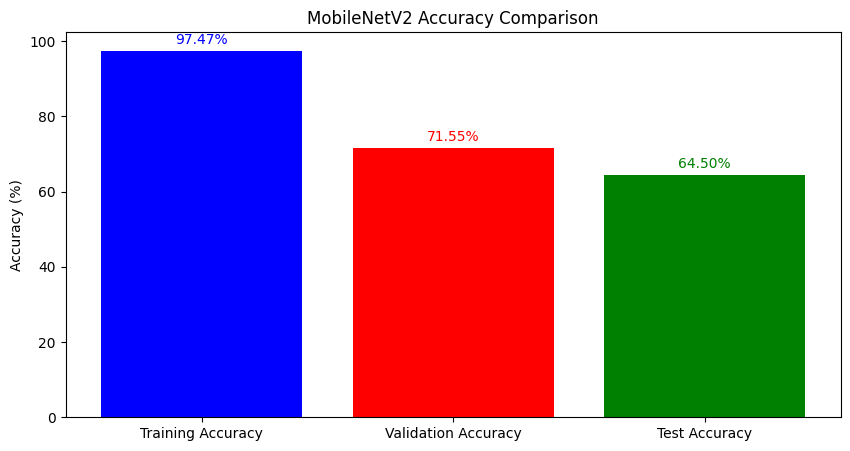

In [ ]:
import matplotlib.pyplot as plt

# Data
categories = ['Training Accuracy', 'Validation Accuracy', 'Test Accuracy']
accuracies_mobileNetV2 = [0.9747313857078552, 0.715534508228302, 0.645008385181427]

# Convert accuracies to percentages
accuracies_percentage_mobileNetV2 = [acc * 100 for acc in accuracies_mobileNetV2]

fig, ax = plt.subplots(figsize=(10, 5))

bars = ax.bar(categories, accuracies_percentage_mobileNetV2, color=['blue', 'red', 'green'])

ax.set_ylabel('Accuracy (%)')
ax.set_title('MobileNetV2 Accuracy Comparison')

# Adding labels outside the bars
for bar, value in zip(bars, accuracies_percentage_mobileNetV2):
    ax.text(bar.get_x() + bar.get_width() / 2, value + 1, f'{value:.2f}%', ha='center', va='bottom', color=bar.get_facecolor())


plt.show()


In [ ]:
y_pred3 = Transfer_model1.predict(pixels_test_rgb)

# Convert one-hot encoded labels back to integer labels
y_true3 = np.argmax(labels_test, axis=1)
y_pred_classes3 = np.argmax(y_pred3, axis=1)

# Print classification report
print("\nClassification Report: Transfer Model MobileNetV2")
print(classification_report(y_true3, y_pred_classes3))

225/225 [==============================] - 7s 31ms/step

Classification Report: Transfer Model MobileNetV2
              precision    recall  f1-score   support

           0       0.51      0.77      0.62       331
           1       1.00      0.38      0.55       432
           2       0.98      0.83      0.90       310
           3       0.46      0.66      0.54       245
           4       0.93      0.57      0.70       498
           5       0.79      0.99      0.88       247
           6       1.00      0.14      0.25       348
           7       0.85      0.88      0.87       436
           8       0.98      0.57      0.72       288
           9       0.61      0.75      0.67       331
          10       0.32      1.00      0.49       209
          11       0.89      0.54      0.67       394
          12       0.42      0.84      0.56       291
          13       0.46      0.64      0.54       246
          14       0.61      0.97      0.75       347
          15       1.00     

In [ ]:
base_model3 = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

base_model3.build((None, 32, 32, 3))

Transfer_model3 = Sequential([
    base_model3,
    GlobalAveragePooling2D(),
    Dense(96, activation='relu'),
    Dense(24, activation='softmax')
])

Transfer_model3.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

Epoch 1/5
687/687 [==============================] - 277s 380ms/step - loss: 2.1989 - accuracy: 0.3207 - val_loss: 6.4044 - val_accuracy: 0.0388
Epoch 2/5
687/687 [==============================] - 242s 352ms/step - loss: 0.6905 - accuracy: 0.7720 - val_loss: 6.4748 - val_accuracy: 0.0457
Epoch 3/5
687/687 [==============================] - 235s 342ms/step - loss: 0.3326 - accuracy: 0.8895 - val_loss: 5.4513 - val_accuracy: 0.0519
Epoch 4/5
687/687 [==============================] - 219s 318ms/step - loss: 0.1910 - accuracy: 0.9387 - val_loss: 3.9207 - val_accuracy: 0.3803
Epoch 5/5
687/687 [==============================] - 211s 307ms/step - loss: 0.1273 - accuracy: 0.9610 - val_loss: 3.3409 - val_accuracy: 0.1555


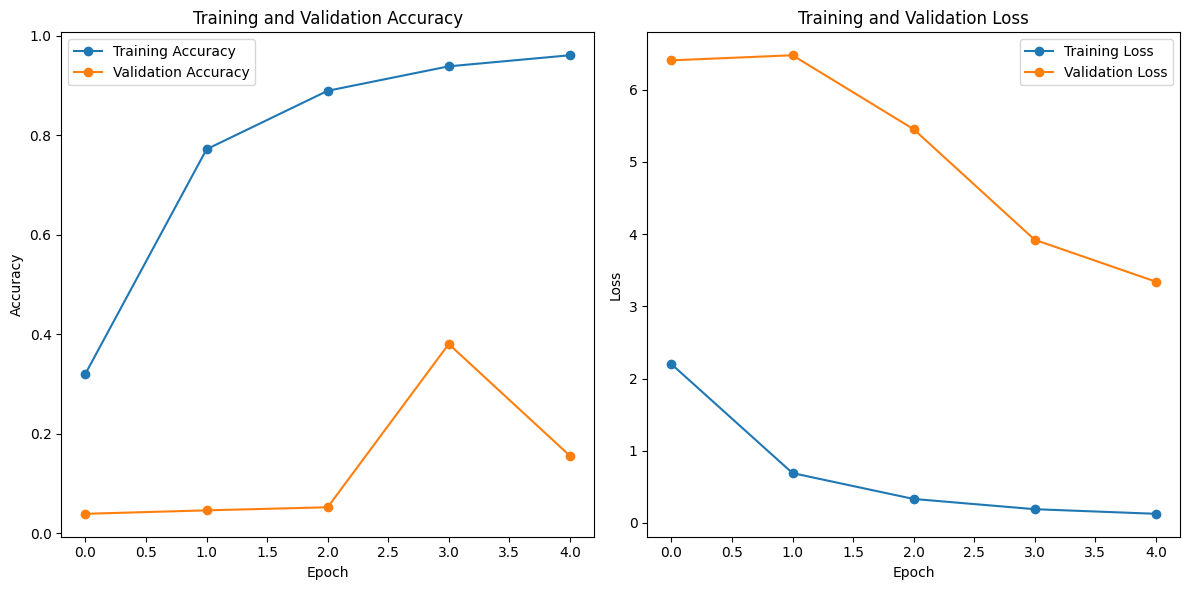

In [ ]:
Transfer_model_history3 = Transfer_model3.fit(pixels_train_rgb, labels_train,
                                              epochs=5,
                                              validation_data=(pixels_val_rgb, labels_val))

# After training
Transfer_model_history_dict3 = Transfer_model_history3.history

# Plotting the training history
plt.figure(figsize=(12, 6))

# Plot Training Accuracy
plt.subplot(1, 2, 1)
plt.plot(Transfer_model_history_dict3['accuracy'], label='Training Accuracy', marker='o')
plt.plot(Transfer_model_history_dict3['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training Loss
plt.subplot(1, 2, 2)
plt.plot(Transfer_model_history_dict3['loss'], label='Training Loss', marker='o')
plt.plot(Transfer_model_history_dict3['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
print("Training Accuracy with EfficientNetB0:", Transfer_model_history_dict3['accuracy'][-1])

_, val_accuracy4 = Transfer_model3.evaluate(pixels_val_rgb, labels_val, verbose=0)
print("Validation Accuracy with EfficientNetB0:", val_accuracy4)

_, test_accuracy4 = Transfer_model3.evaluate(pixels_test_rgb, labels_test, verbose=0)
print("Test Accuracy with EfficientNetB0:", test_accuracy4)

Training Accuracy with EfficientNetB0: 0.9609816074371338
Validation Accuracy with EfficientNetB0: 0.15552721917629242
Test Accuracy with EfficientNetB0: 0.14821527898311615


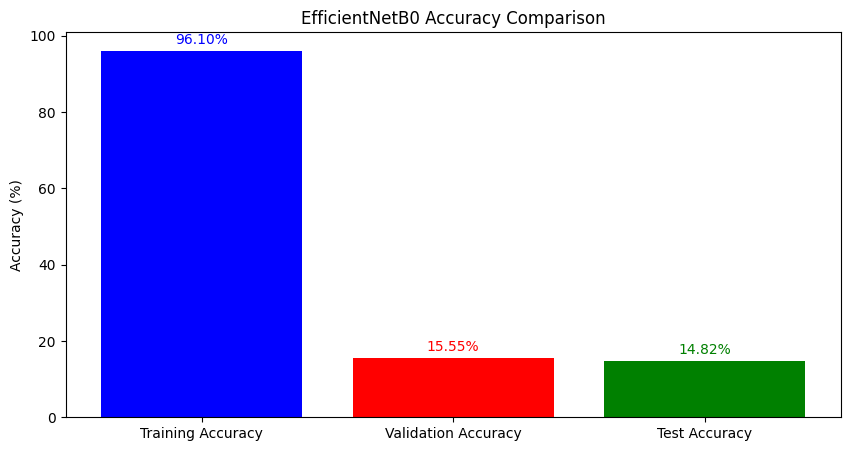

In [ ]:
import matplotlib.pyplot as plt

# Data
categories = ['Training Accuracy', 'Validation Accuracy', 'Test Accuracy']
accuracies = [0.9609816074371338, 0.15552721917629242, 0.14821527898311615]

# Convert accuracies to percentages
accuracies_percentage = [acc * 100 for acc in accuracies]

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))

bars = ax.bar(categories, accuracies_percentage, color=['blue', 'red', 'green'])

ax.set_ylabel('Accuracy (%)')
ax.set_title('EfficientNetB0 Accuracy Comparison')

# Adding labels outside the bars
for bar, value in zip(bars, accuracies_percentage):
    ax.text(bar.get_x() + bar.get_width() / 2, value + 1, f'{value:.2f}%', ha='center', va='bottom', color=bar.get_facecolor())


plt.show()


In [ ]:
y_pred4 = Transfer_model3.predict(pixels_test_rgb)

# Convert one-hot encoded labels back to integer labels
y_true4 = np.argmax(labels_test, axis=1)
y_pred_classes4 = np.argmax(y_pred4, axis=1)

# Print classification report
print("\nClassification Report: Transfer Model EfficientNetB0")
print(classification_report(y_true4, y_pred_classes4))

225/225 [==============================] - 18s 60ms/step

Classification Report: Transfer Model EfficientNetB0
              precision    recall  f1-score   support

           0       0.23      0.41      0.30       331
           1       0.00      0.00      0.00       432
           2       1.00      0.05      0.09       310
           3       0.44      0.02      0.03       245
           4       0.00      0.00      0.00       498
           5       0.00      0.00      0.00       247
           6       0.81      0.21      0.33       348
           7       0.93      0.08      0.16       436
           8       0.09      0.46      0.16       288
           9       0.00      0.00      0.00       331
          10       0.00      0.00      0.00       209
          11       0.00      0.00      0.00       394
          12       0.48      0.10      0.17       291
          13       0.10      0.00      0.01       246
          14       0.43      0.01      0.02       347
          15       0.54 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


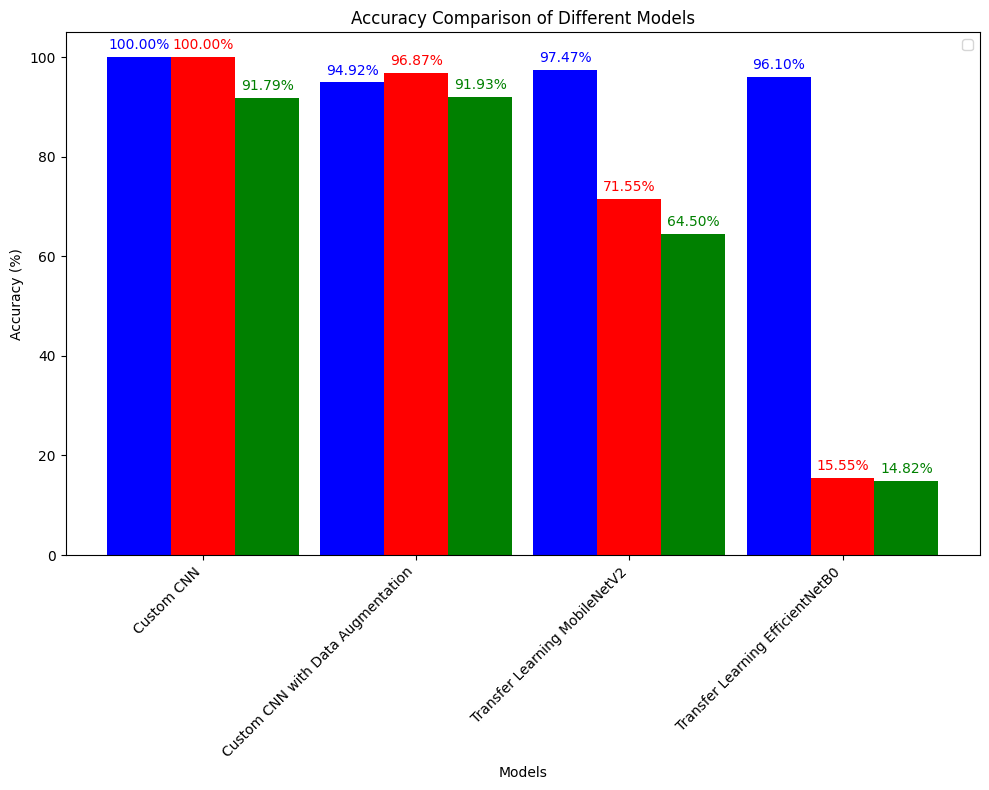

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Data
categories = [
    'Custom CNN Model',
    'Custom CNN Model with Data Augmentation',
    'Transfer Learning MobileNetV2',
    'Transfer Learning EfficientNetB0'
]

# Training, validation, and test accuracies (in raw values)
training_accuracies = [1.0, 0.9492351412773132, 0.9747313857078552, 0.9609816074371338]
validation_accuracies = [1.0, 0.9686760306358337, 0.715534508228302, 0.15552721917629242]
test_accuracies = [0.9178750514984131, 0.9192693829536438, 0.645008385181427, 0.14821527898311615]

# Convert accuracies to percentages
training_accuracies_percentage = [acc * 100 for acc in training_accuracies]
validation_accuracies_percentage = [acc * 100 for acc in validation_accuracies]
test_accuracies_percentage = [acc * 100 for acc in test_accuracies]
# Plotting
bar_width = 0.3
index = np.arange(len(categories))
fig, ax = plt.subplots(figsize=(10, 8))

bars1 = ax.bar(index - bar_width, training_accuracies_percentage, bar_width, color='blue')
bars2 = ax.bar(index, validation_accuracies_percentage, bar_width, color='red')
bars3 = ax.bar(index + bar_width, test_accuracies_percentage, bar_width, color='green')

ax.set_xlabel('Models')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Accuracy Comparison of Different Models')
ax.set_xticks(index)
ax.set_xticklabels(categories, rotation=45, ha='right')

# Adding labels outside the bars
for bar, value in zip(bars1, training_accuracies_percentage):
    ax.text(bar.get_x() + bar.get_width() / 2, value + 1, f'{value:.2f}%', ha='center', va='bottom', color='blue')

for bar, value in zip(bars2, validation_accuracies_percentage):
    ax.text(bar.get_x() + bar.get_width() / 2, value + 1, f'{value:.2f}%', ha='center', va='bottom', color='red')

for bar, value in zip(bars3, test_accuracies_percentage):
    ax.text(bar.get_x() + bar.get_width() / 2, value + 1, f'{value:.2f}%', ha='center', va='bottom', color='green')

plt.legend()

plt.tight_layout()
plt.show()

# CNN Model without Augmentation

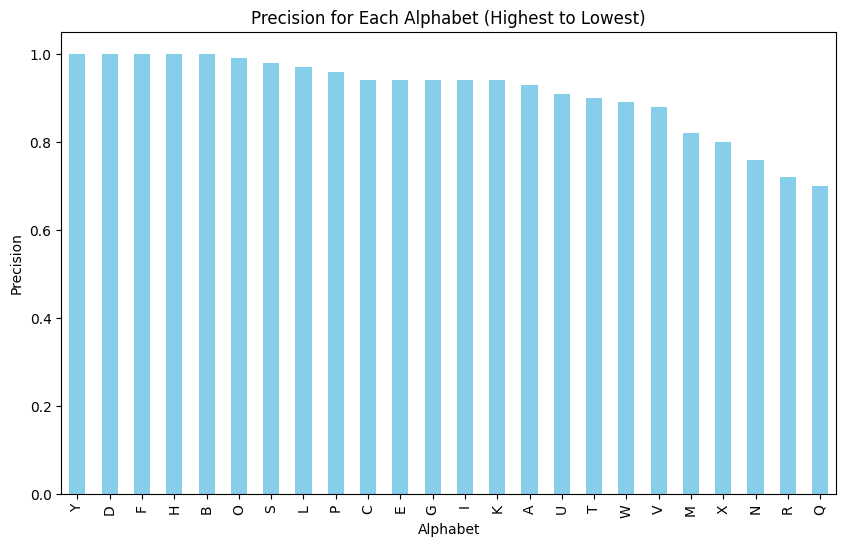

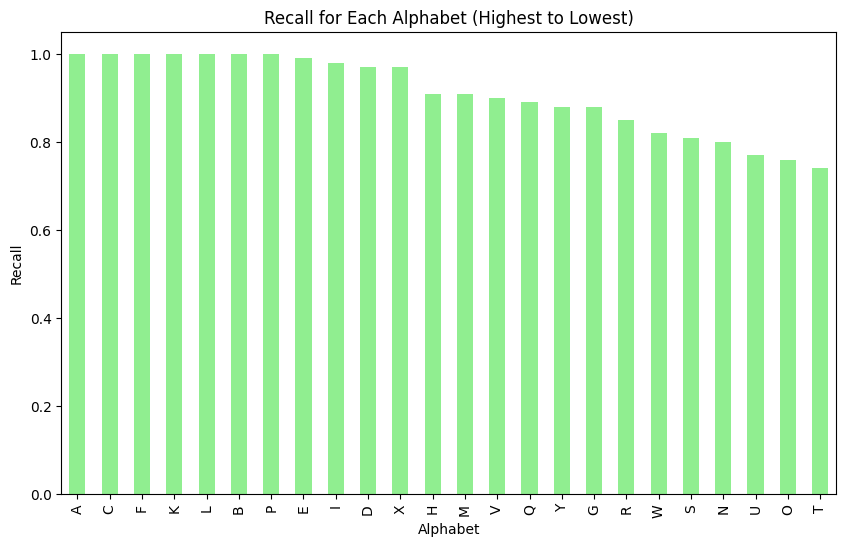

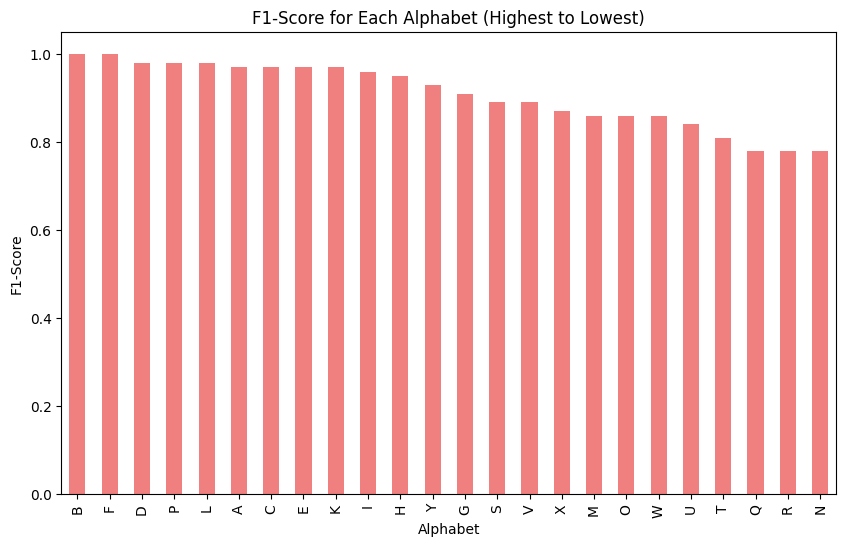

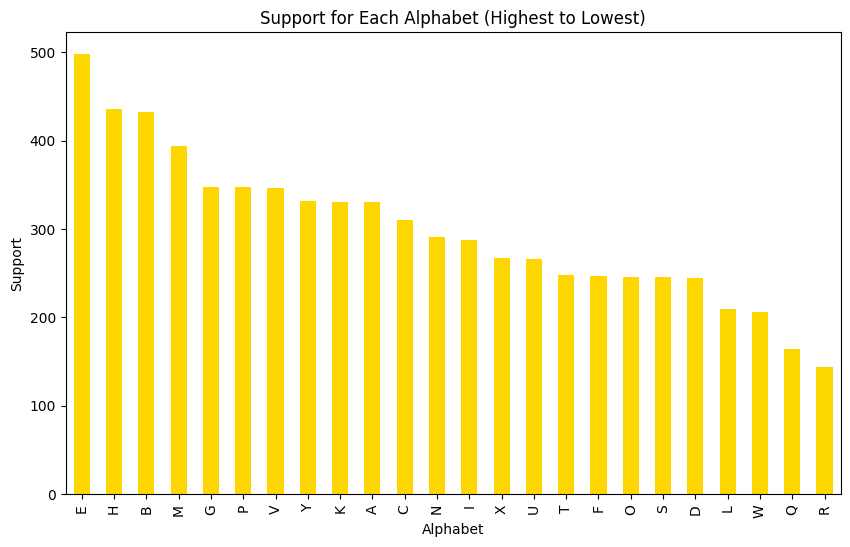

In [ ]:
data = {
    'A': {'precision': 0.93, 'recall': 1.00, 'f1-score': 0.97, 'support': 331},
    'B': {'precision': 1.00, 'recall': 1.00, 'f1-score': 1.00, 'support': 432},
    'C': {'precision': 0.94, 'recall': 1.00, 'f1-score': 0.97, 'support': 310},
    'D': {'precision': 1.00, 'recall': 0.97, 'f1-score': 0.98, 'support': 245},
    'E': {'precision': 0.94, 'recall': 0.99, 'f1-score': 0.97, 'support': 498},
    'F': {'precision': 1.00, 'recall': 1.00, 'f1-score': 1.00, 'support': 247},
    'G': {'precision': 0.94, 'recall': 0.88, 'f1-score': 0.91, 'support': 348},
    'H': {'precision': 1.00, 'recall': 0.91, 'f1-score': 0.95, 'support': 436},
    'I': {'precision': 0.94, 'recall': 0.98, 'f1-score': 0.96, 'support': 288},
    'K': {'precision': 0.94, 'recall': 1.00, 'f1-score': 0.97, 'support': 331},
    'L': {'precision': 0.97, 'recall': 1.00, 'f1-score': 0.98, 'support': 209},
    'M': {'precision': 0.82, 'recall': 0.91, 'f1-score': 0.86, 'support': 394},
    'N': {'precision': 0.76, 'recall': 0.80, 'f1-score': 0.78, 'support': 291},
    'O': {'precision': 0.99, 'recall': 0.76, 'f1-score': 0.86, 'support': 246},
    'P': {'precision': 0.96, 'recall': 1.00, 'f1-score': 0.98, 'support': 347},
    'Q': {'precision': 0.70, 'recall': 0.89, 'f1-score': 0.78, 'support': 164},
    'R': {'precision': 0.72, 'recall': 0.85, 'f1-score': 0.78, 'support': 144},
    'S': {'precision': 0.98, 'recall': 0.81, 'f1-score': 0.89, 'support': 246},
    'T': {'precision': 0.90, 'recall': 0.74, 'f1-score': 0.81, 'support': 248},
    'U': {'precision': 0.91, 'recall': 0.77, 'f1-score': 0.84, 'support': 266},
    'V': {'precision': 0.88, 'recall': 0.90, 'f1-score': 0.89, 'support': 346},
    'W': {'precision': 0.89, 'recall': 0.82, 'f1-score': 0.86, 'support': 206},
    'X': {'precision': 0.80, 'recall': 0.97, 'f1-score': 0.87, 'support': 267},
    'Y': {'precision': 1.00, 'recall': 0.88, 'f1-score': 0.93, 'support': 332}
}

# Create a DataFrame for easier sorting
df = pd.DataFrame(data).transpose()

# Sort the DataFrame by precision, recall, f1-score, and support
df_precision = df.sort_values(by='precision', ascending=False)
df_recall = df.sort_values(by='recall', ascending=False)
df_f1_score = df.sort_values(by='f1-score', ascending=False)
df_support = df.sort_values(by='support', ascending=False)

# Plot precision
plt.figure(figsize=(10, 6))
df_precision['precision'].plot(kind='bar', color='skyblue')
plt.title('Precision for Each Alphabet (Highest to Lowest)')
plt.xlabel('Alphabet')
plt.ylabel('Precision')
plt.show()

# Plot recall
plt.figure(figsize=(10, 6))
df_recall['recall'].plot(kind='bar', color='lightgreen')
plt.title('Recall for Each Alphabet (Highest to Lowest)')
plt.xlabel('Alphabet')
plt.ylabel('Recall')
plt.show()

# Plot f1-score
plt.figure(figsize=(10, 6))
df_f1_score['f1-score'].plot(kind='bar', color='lightcoral')
plt.title('F1-Score for Each Alphabet (Highest to Lowest)')
plt.xlabel('Alphabet')
plt.ylabel('F1-Score')
plt.show()

# Plot support
plt.figure(figsize=(10, 6))
df_support['support'].plot(kind='bar', color='gold')
plt.title('Support for Each Alphabet (Highest to Lowest)')
plt.xlabel('Alphabet')
plt.ylabel('Support')
plt.show()

# CNN Model with Augmentation

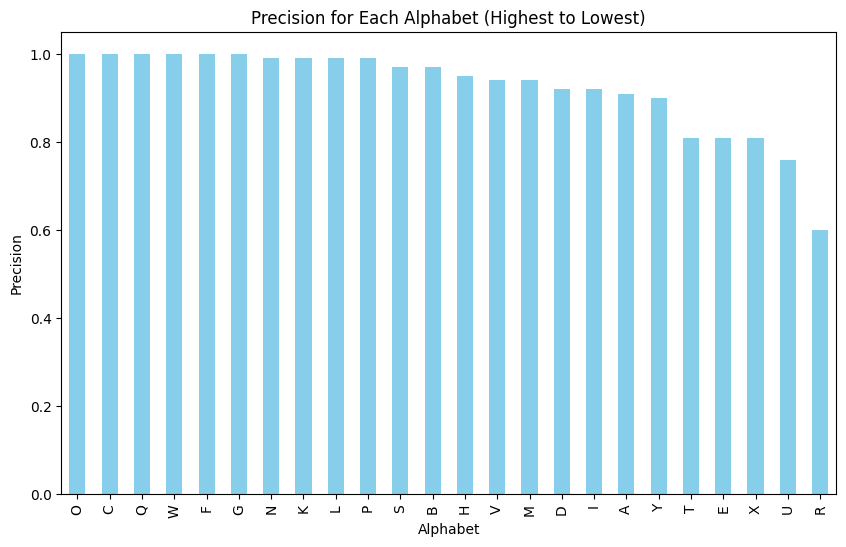

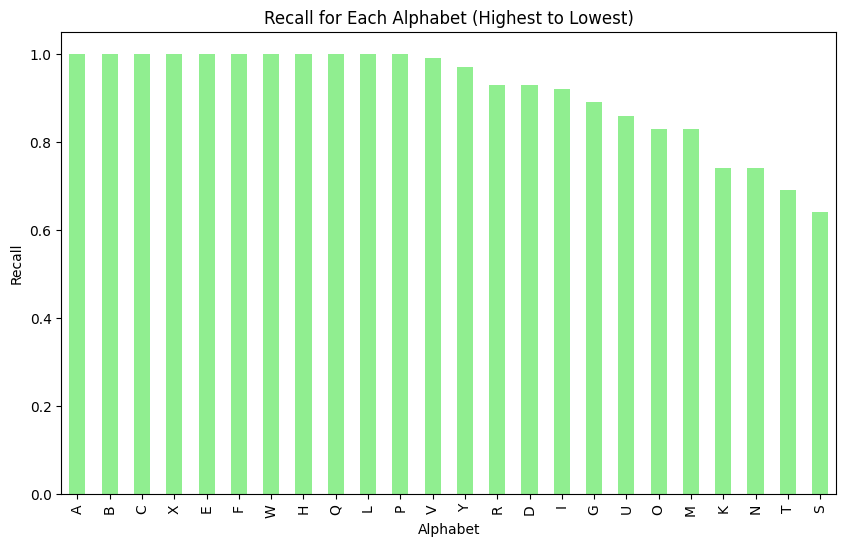

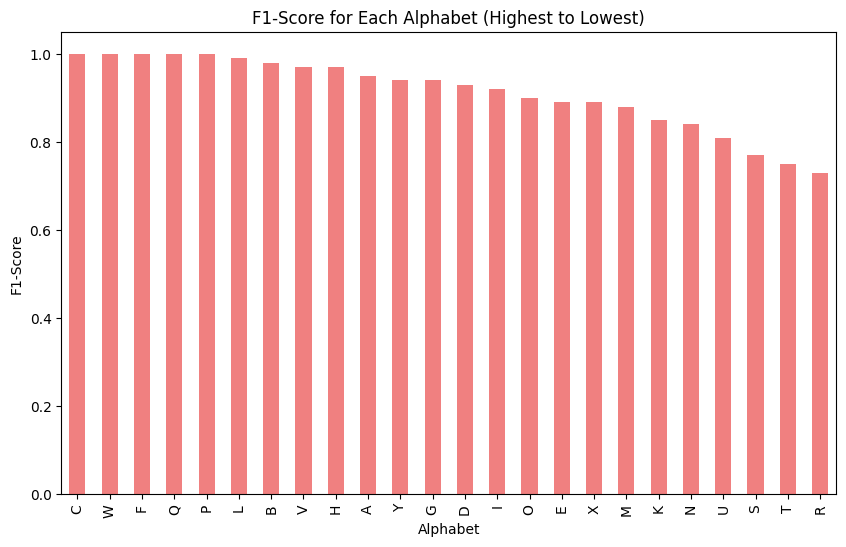

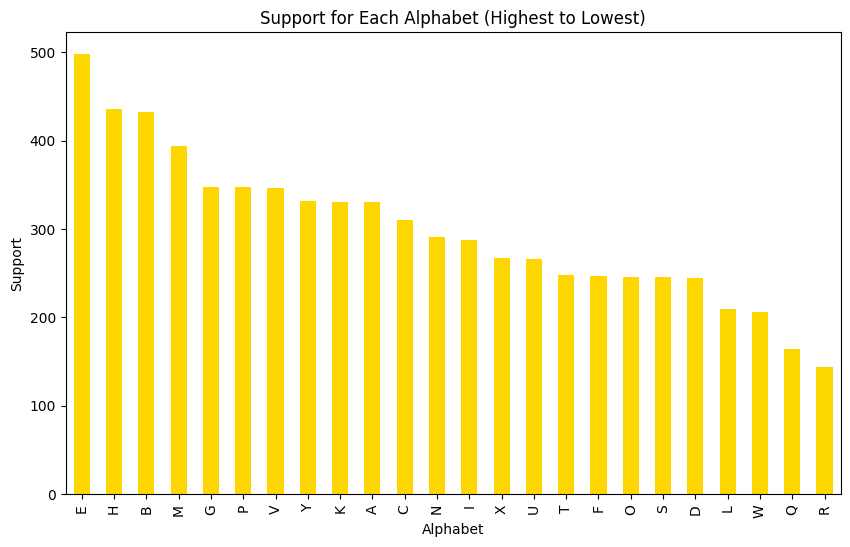

In [ ]:
data_aug = {
    'A': {'precision': 0.91, 'recall': 1.00, 'f1-score': 0.95, 'support': 331},
    'B': {'precision': 0.97, 'recall': 1.00, 'f1-score': 0.98, 'support': 432},
    'C': {'precision': 1.00, 'recall': 1.00, 'f1-score': 1.00, 'support': 310},
    'D': {'precision': 0.92, 'recall': 0.93, 'f1-score': 0.93, 'support': 245},
    'E': {'precision': 0.81, 'recall': 1.00, 'f1-score': 0.89, 'support': 498},
    'F': {'precision': 1.00, 'recall': 1.00, 'f1-score': 1.00, 'support': 247},
    'G': {'precision': 1.00, 'recall': 0.89, 'f1-score': 0.94, 'support': 348},
    'H': {'precision': 0.95, 'recall': 1.00, 'f1-score': 0.97, 'support': 436},
    'I': {'precision': 0.92, 'recall': 0.92, 'f1-score': 0.92, 'support': 288},
    'K': {'precision': 0.99, 'recall': 0.74, 'f1-score': 0.85, 'support': 331},
    'L': {'precision': 0.99, 'recall': 1.00, 'f1-score': 0.99, 'support': 209},
    'M': {'precision': 0.94, 'recall': 0.83, 'f1-score': 0.88, 'support': 394},
    'N': {'precision': 0.99, 'recall': 0.74, 'f1-score': 0.84, 'support': 291},
    'O': {'precision': 1.00, 'recall': 0.83, 'f1-score': 0.90, 'support': 246},
    'P': {'precision': 0.99, 'recall': 1.00, 'f1-score': 1.00, 'support': 347},
    'Q': {'precision': 1.00, 'recall': 1.00, 'f1-score': 1.00, 'support': 164},
    'R': {'precision': 0.60, 'recall': 0.93, 'f1-score': 0.73, 'support': 144},
    'S': {'precision': 0.97, 'recall': 0.64, 'f1-score': 0.77, 'support': 246},
    'T': {'precision': 0.81, 'recall': 0.69, 'f1-score': 0.75, 'support': 248},
    'U': {'precision': 0.76, 'recall': 0.86, 'f1-score': 0.81, 'support': 266},
    'V': {'precision': 0.94, 'recall': 0.99, 'f1-score': 0.97, 'support': 346},
    'W': {'precision': 1.00, 'recall': 1.00, 'f1-score': 1.00, 'support': 206},
    'X': {'precision': 0.81, 'recall': 1.00, 'f1-score': 0.89, 'support': 267},
    'Y': {'precision': 0.90, 'recall': 0.97, 'f1-score': 0.94, 'support': 332}
}
# Create a DataFrame for easier sorting
df_aug = pd.DataFrame(data_aug).transpose()

# Sort the DataFrame by precision, recall, f1-score, and support
df_precision_aug = df_aug.sort_values(by='precision', ascending=False)
df_recall_aug = df_aug.sort_values(by='recall', ascending=False)
df_f1_score_aug = df_aug.sort_values(by='f1-score', ascending=False)
df_support_aug = df_aug.sort_values(by='support', ascending=False)

# Plot precision
plt.figure(figsize=(10, 6))
df_precision_aug['precision'].plot(kind='bar', color='skyblue')
plt.title('Precision for Each Alphabet (Highest to Lowest)')
plt.xlabel('Alphabet')
plt.ylabel('Precision')
plt.show()

# Plot recall
plt.figure(figsize=(10, 6))
df_recall_aug['recall'].plot(kind='bar', color='lightgreen')
plt.title('Recall for Each Alphabet (Highest to Lowest)')
plt.xlabel('Alphabet')
plt.ylabel('Recall')
plt.show()

# Plot f1-score
plt.figure(figsize=(10, 6))
df_f1_score_aug['f1-score'].plot(kind='bar', color='lightcoral')
plt.title('F1-Score for Each Alphabet (Highest to Lowest)')
plt.xlabel('Alphabet')
plt.ylabel('F1-Score')
plt.show()

# Plot support
plt.figure(figsize=(10, 6))
df_support_aug['support'].plot(kind='bar', color='gold')
plt.title('Support for Each Alphabet (Highest to Lowest)')
plt.xlabel('Alphabet')
plt.ylabel('Support')
plt.show()

# MobileNetV2

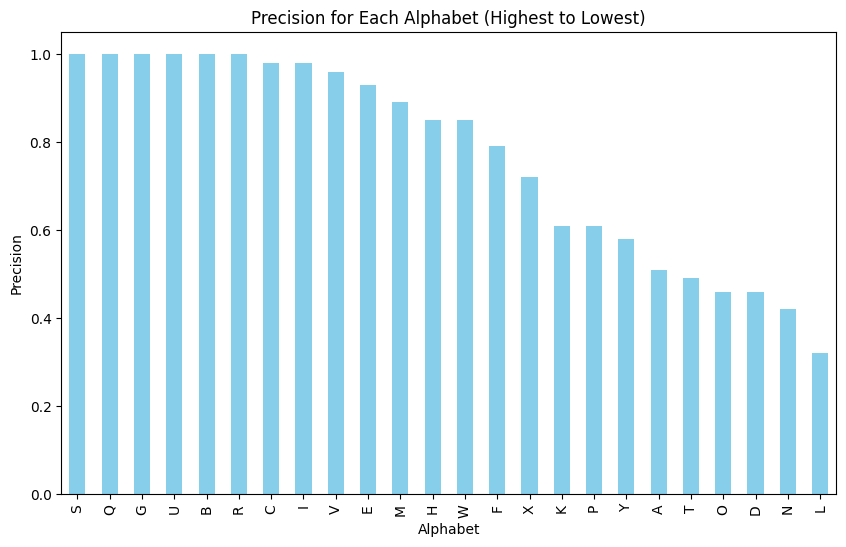

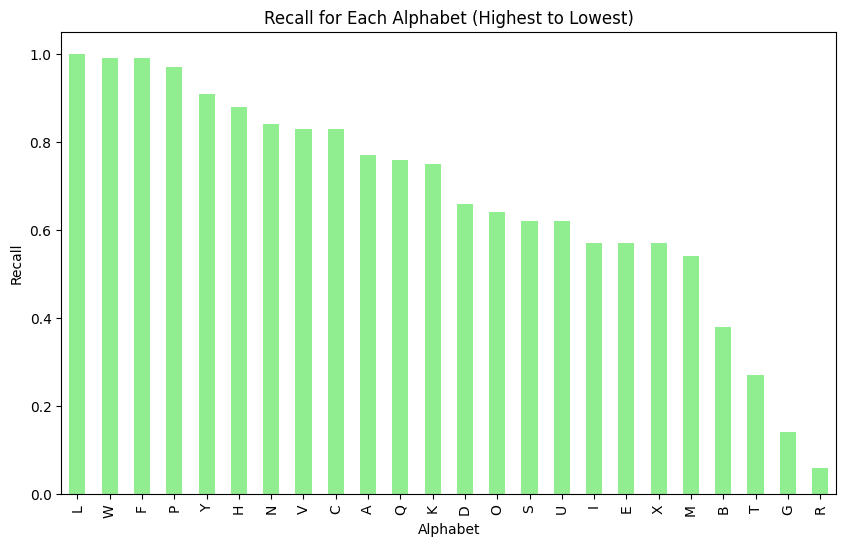

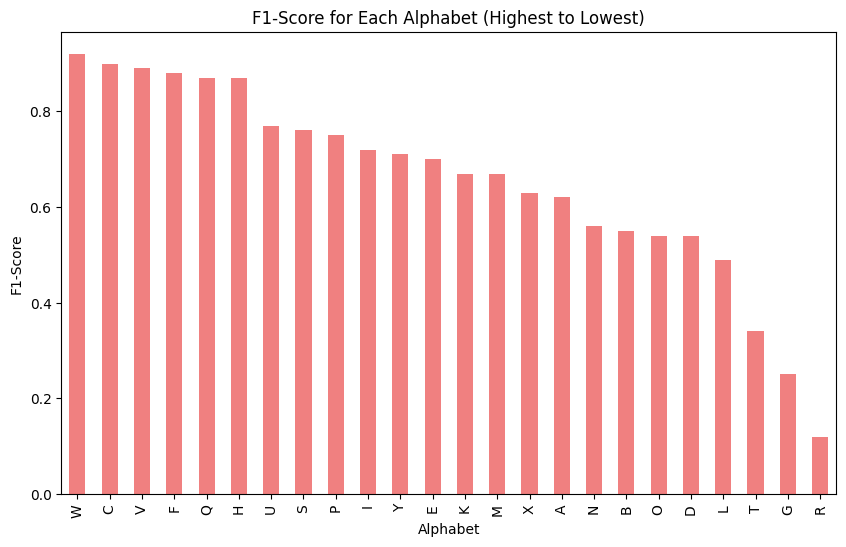

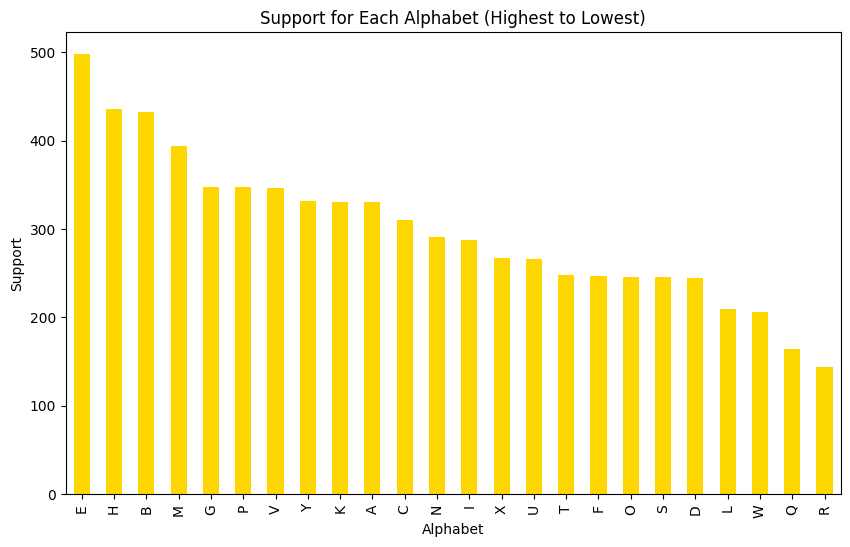

In [ ]:
data_mobile = {
    'A': {'precision': 0.51, 'recall': 0.77, 'f1-score': 0.62, 'support': 331},
    'B': {'precision': 1.00, 'recall': 0.38, 'f1-score': 0.55, 'support': 432},
    'C': {'precision': 0.98, 'recall': 0.83, 'f1-score': 0.90, 'support': 310},
    'D': {'precision': 0.46, 'recall': 0.66, 'f1-score': 0.54, 'support': 245},
    'E': {'precision': 0.93, 'recall': 0.57, 'f1-score': 0.70, 'support': 498},
    'F': {'precision': 0.79, 'recall': 0.99, 'f1-score': 0.88, 'support': 247},
    'G': {'precision': 1.00, 'recall': 0.14, 'f1-score': 0.25, 'support': 348},
    'H': {'precision': 0.85, 'recall': 0.88, 'f1-score': 0.87, 'support': 436},
    'I': {'precision': 0.98, 'recall': 0.57, 'f1-score': 0.72, 'support': 288},
    'K': {'precision': 0.61, 'recall': 0.75, 'f1-score': 0.67, 'support': 331},
    'L': {'precision': 0.32, 'recall': 1.00, 'f1-score': 0.49, 'support': 209},
    'M': {'precision': 0.89, 'recall': 0.54, 'f1-score': 0.67, 'support': 394},
    'N': {'precision': 0.42, 'recall': 0.84, 'f1-score': 0.56, 'support': 291},
    'O': {'precision': 0.46, 'recall': 0.64, 'f1-score': 0.54, 'support': 246},
    'P': {'precision': 0.61, 'recall': 0.97, 'f1-score': 0.75, 'support': 347},
    'Q': {'precision': 1.00, 'recall': 0.76, 'f1-score': 0.87, 'support': 164},
    'R': {'precision': 1.00, 'recall': 0.06, 'f1-score': 0.12, 'support': 144},
    'S': {'precision': 1.00, 'recall': 0.62, 'f1-score': 0.76, 'support': 246},
    'T': {'precision': 0.49, 'recall': 0.27, 'f1-score': 0.34, 'support': 248},
    'U': {'precision': 1.00, 'recall': 0.62, 'f1-score': 0.77, 'support': 266},
    'V': {'precision': 0.96, 'recall': 0.83, 'f1-score': 0.89, 'support': 346},
    'W': {'precision': 0.85, 'recall': 0.99, 'f1-score': 0.92, 'support': 206},
    'X': {'precision': 0.72, 'recall': 0.57, 'f1-score': 0.63, 'support': 267},
    'Y': {'precision': 0.58, 'recall': 0.91, 'f1-score': 0.71, 'support': 332}
}

# Create a DataFrame for easier sorting
df_mobile = pd.DataFrame(data_mobile).transpose()

# Sort the DataFrame by precision, recall, f1-score, and support
df_precision_mobile = df_mobile.sort_values(by='precision', ascending=False)
df_recall_mobile = df_mobile.sort_values(by='recall', ascending=False)
df_f1_score_mobile = df_mobile.sort_values(by='f1-score', ascending=False)
df_support_mobile = df_mobile.sort_values(by='support', ascending=False)

# Plot precision
plt.figure(figsize=(10, 6))
df_precision_mobile['precision'].plot(kind='bar', color='skyblue')
plt.title('Precision for Each Alphabet (Highest to Lowest)')
plt.xlabel('Alphabet')
plt.ylabel('Precision')
plt.show()

# Plot recall
plt.figure(figsize=(10, 6))
df_recall_mobile['recall'].plot(kind='bar', color='lightgreen')
plt.title('Recall for Each Alphabet (Highest to Lowest)')
plt.xlabel('Alphabet')
plt.ylabel('Recall')
plt.show()

# Plot f1-score
plt.figure(figsize=(10, 6))
df_f1_score_mobile['f1-score'].plot(kind='bar', color='lightcoral')
plt.title('F1-Score for Each Alphabet (Highest to Lowest)')
plt.xlabel('Alphabet')
plt.ylabel('F1-Score')
plt.show()

# Plot support
plt.figure(figsize=(10, 6))
df_support_mobile['support'].plot(kind='bar', color='gold')
plt.title('Support for Each Alphabet (Highest to Lowest)')
plt.xlabel('Alphabet')
plt.ylabel('Support')
plt.show()


# EfficientNetB0

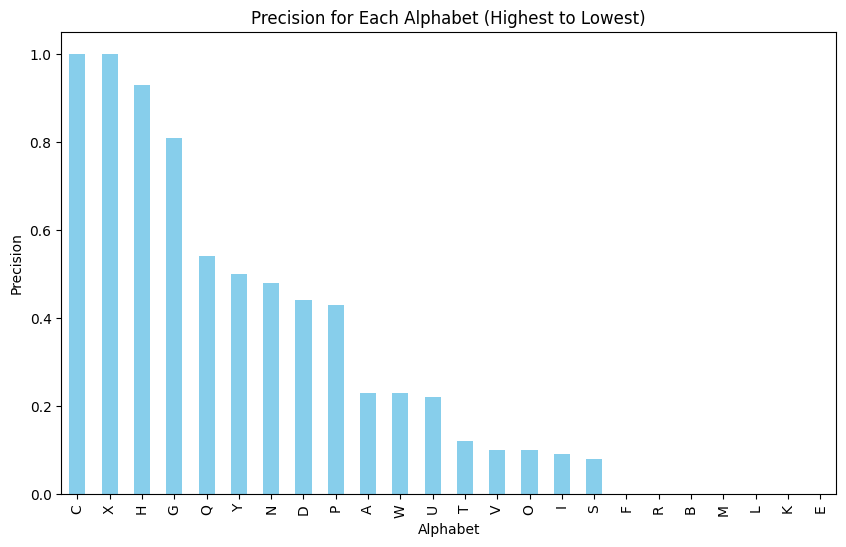

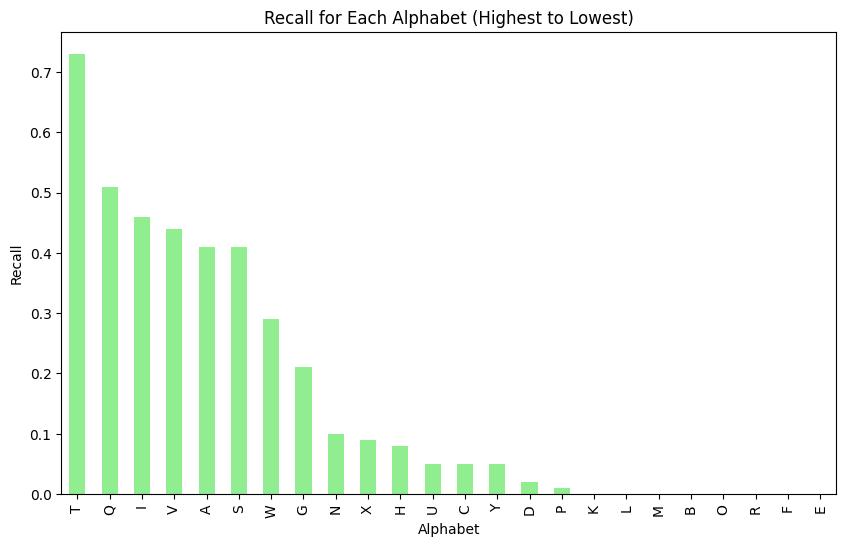

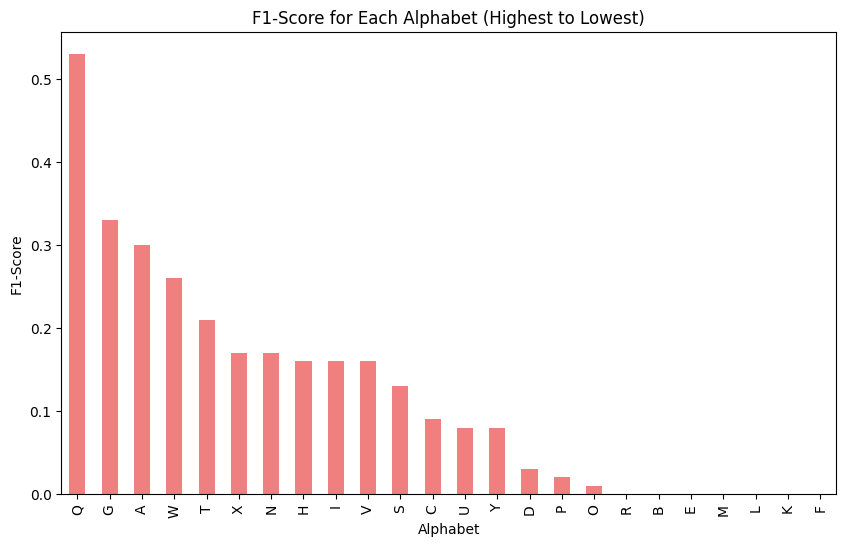

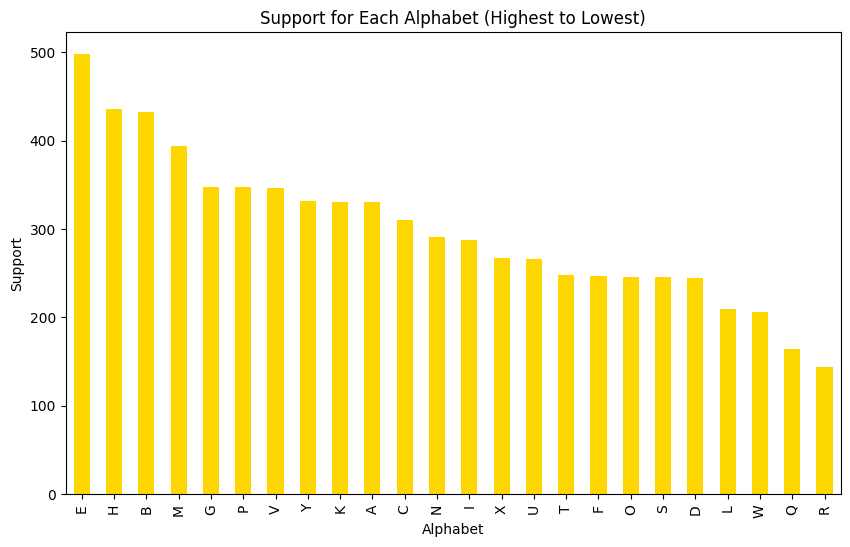

In [ ]:
data_efficient = {
    'A': {'precision': 0.23, 'recall': 0.41, 'f1-score': 0.30, 'support': 331},
    'B': {'precision': 0.00, 'recall': 0.00, 'f1-score': 0.00, 'support': 432},
    'C': {'precision': 1.00, 'recall': 0.05, 'f1-score': 0.09, 'support': 310},
    'D': {'precision': 0.44, 'recall': 0.02, 'f1-score': 0.03, 'support': 245},
    'E': {'precision': 0.00, 'recall': 0.00, 'f1-score': 0.00, 'support': 498},
    'F': {'precision': 0.00, 'recall': 0.00, 'f1-score': 0.00, 'support': 247},
    'G': {'precision': 0.81, 'recall': 0.21, 'f1-score': 0.33, 'support': 348},
    'H': {'precision': 0.93, 'recall': 0.08, 'f1-score': 0.16, 'support': 436},
    'I': {'precision': 0.09, 'recall': 0.46, 'f1-score': 0.16, 'support': 288},
    'K': {'precision': 0.00, 'recall': 0.00, 'f1-score': 0.00, 'support': 331},
    'L': {'precision': 0.00, 'recall': 0.00, 'f1-score': 0.00, 'support': 209},
    'M': {'precision': 0.00, 'recall': 0.00, 'f1-score': 0.00, 'support': 394},
    'N': {'precision': 0.48, 'recall': 0.10, 'f1-score': 0.17, 'support': 291},
    'O': {'precision': 0.10, 'recall': 0.00, 'f1-score': 0.01, 'support': 246},
    'P': {'precision': 0.43, 'recall': 0.01, 'f1-score': 0.02, 'support': 347},
    'Q': {'precision': 0.54, 'recall': 0.51, 'f1-score': 0.53, 'support': 164},
    'R': {'precision': 0.00, 'recall': 0.00, 'f1-score': 0.00, 'support': 144},
    'S': {'precision': 0.08, 'recall': 0.41, 'f1-score': 0.13, 'support': 246},
    'T': {'precision': 0.12, 'recall': 0.73, 'f1-score': 0.21, 'support': 248},
    'U': {'precision': 0.22, 'recall': 0.05, 'f1-score': 0.08, 'support': 266},
    'V': {'precision': 0.10, 'recall': 0.44, 'f1-score': 0.16, 'support': 346},
    'W': {'precision': 0.23, 'recall': 0.29, 'f1-score': 0.26, 'support': 206},
    'X': {'precision': 1.00, 'recall': 0.09, 'f1-score': 0.17, 'support': 267},
    'Y': {'precision': 0.50, 'recall': 0.05, 'f1-score': 0.08, 'support': 332}
}

# Create a DataFrame for easier sorting
df_efficient = pd.DataFrame(data_efficient).transpose()

# Sort the DataFrame by precision, recall, f1-score, and support
df_precision_efficient = df_efficient.sort_values(by='precision', ascending=False)
df_recall_efficient = df_efficient.sort_values(by='recall', ascending=False)
df_f1_score_efficient = df_efficient.sort_values(by='f1-score', ascending=False)
df_support_efficient = df_efficient.sort_values(by='support', ascending=False)

# Plot precision
plt.figure(figsize=(10, 6))
df_precision_efficient['precision'].plot(kind='bar', color='skyblue')
plt.title('Precision for Each Alphabet (Highest to Lowest)')
plt.xlabel('Alphabet')
plt.ylabel('Precision')
plt.show()

# Plot recall
plt.figure(figsize=(10, 6))
df_recall_efficient['recall'].plot(kind='bar', color='lightgreen')
plt.title('Recall for Each Alphabet (Highest to Lowest)')
plt.xlabel('Alphabet')
plt.ylabel('Recall')
plt.show()

# Plot f1-score
plt.figure(figsize=(10, 6))
df_f1_score_efficient['f1-score'].plot(kind='bar', color='lightcoral')
plt.title('F1-Score for Each Alphabet (Highest to Lowest)')
plt.xlabel('Alphabet')
plt.ylabel('F1-Score')
plt.show()

# Plot support
plt.figure(figsize=(10, 6))
df_support_efficient['support'].plot(kind='bar', color='gold')
plt.title('Support for Each Alphabet (Highest to Lowest)')
plt.xlabel('Alphabet')
plt.ylabel('Support')
plt.show()